# Hyper Parameter Optimization For K-Nearest Neighbor

In [2]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'KNN'

In [3]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\Scripts_git\\SingleModels\\KNN'

In [4]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.draw import plot_feature_importance, plot_feature_importance
from Utools.SingleModel import SingleModel

In [8]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

## Load Data

In [6]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [ ]:
# using random search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimization begin...")
# define the parameter distributions  for the KNN model
param_distributions = {
    'n_neighbors': np.arange(3, 100, 8) + [21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],    
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
knn = KNeighborsRegressor(n_jobs=-1)
# create a randomized search CV object
# using n_iter=50 for a faster search, you can increase this for better results
# forget to assign metrics score, the default is R2 score
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_distributions,
                n_iter=50, cv=kf, verbose=2, random_state=RANDOM_SEED, 
                return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(dft_train_X, dft_train_y)


['DFT KNN'] HP optimization begin...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsRegressor(n_jobs=-1), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104, 112, 120]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True, verbose=2)

In [19]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = random_search.best_score_
print(f"Best Cross-Validation R2: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_r2'] = results['mean_test_score']
results['train_r2'] = results['mean_train_score']
# sort the results by test RMSE
results_sorted = results.sort_values('test_r2', ascending=False)
results_sorted = results_sorted[['rank_test_score', 'param_n_neighbors', 
                               'param_weights', 'param_p',
                               'train_r2', 'test_r2']] 
# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'dft_grid_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': np.int64(24)}
Best Cross-Validation R2: 0.6440


,rank_test_score,param_n_neighbors,param_weights,param_p,train_r2,test_r2
35,1,24,distance,1,0.992057,0.643953
5,2,32,distance,1,0.992057,0.637011
22,3,40,distance,1,0.992057,0.630932
10,4,48,distance,1,0.992057,0.625701
6,5,56,distance,1,0.992057,0.620842


### Overfitting check

####################################################################################################
[DFT - KNN] Training KNN on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating DFT KNN on DFT train set:


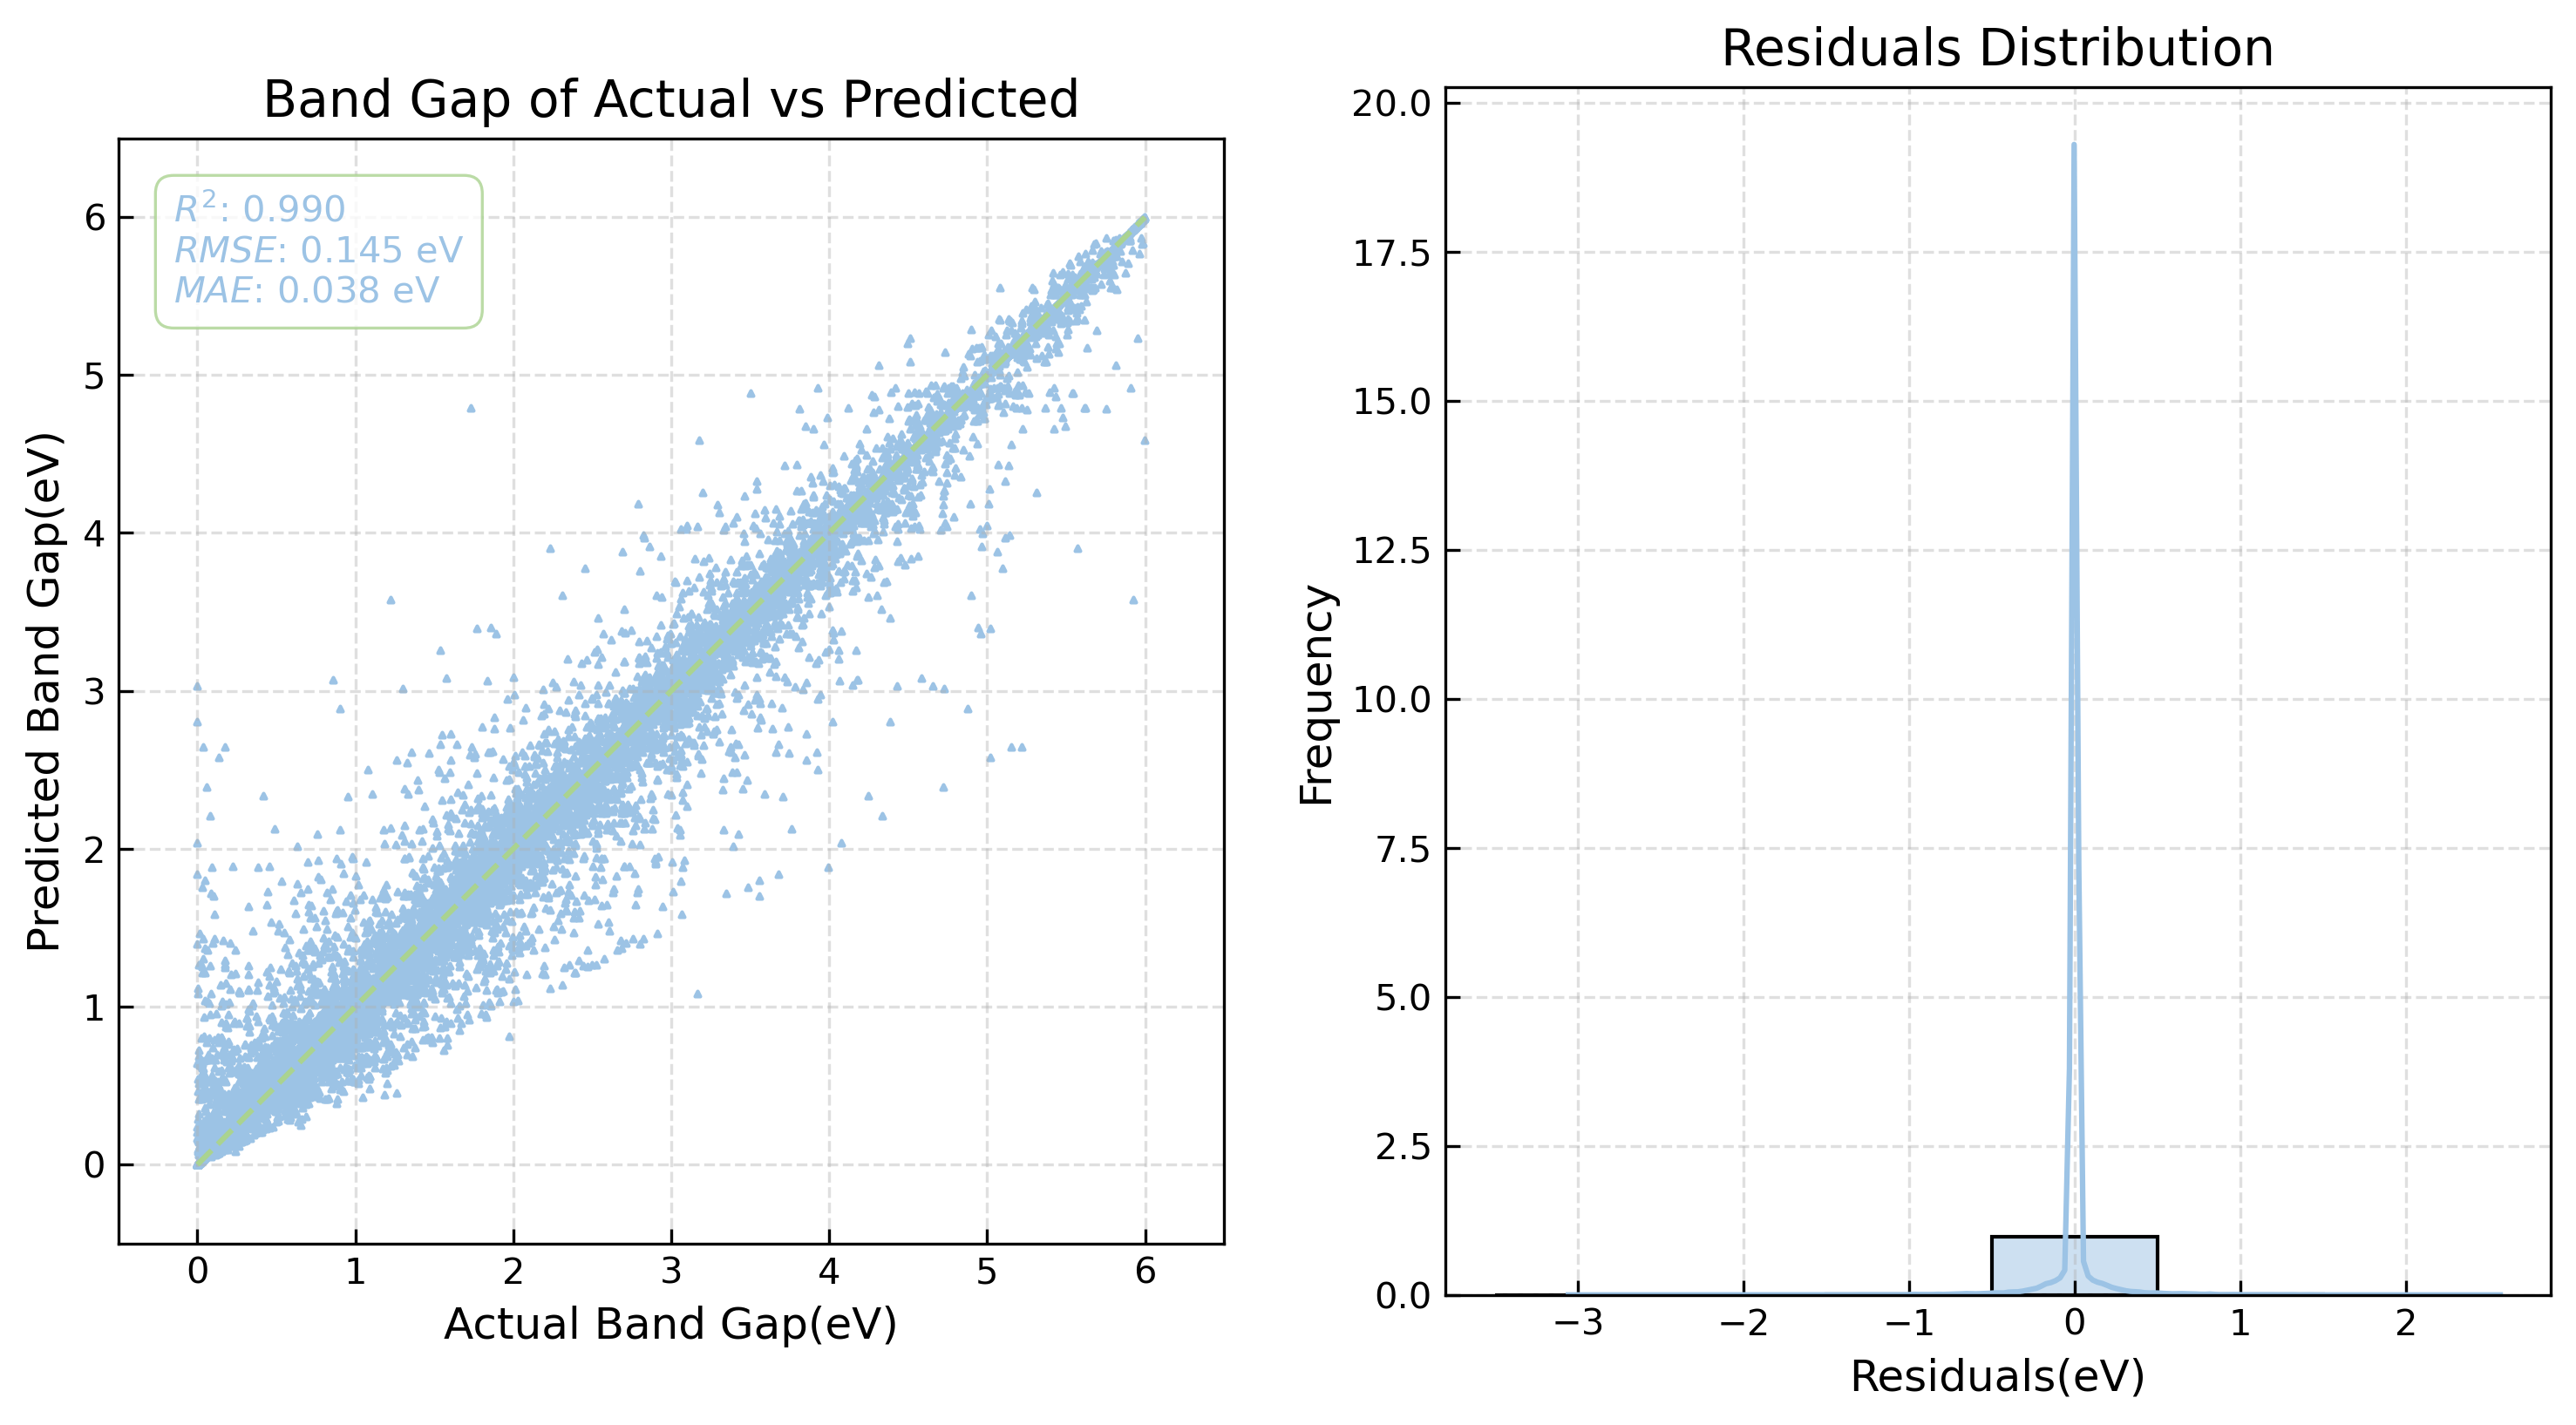


Model Evaluation Results:
Test set: R²: 0.9903 RMSE: 0.1455 MAE: 0.0377
[Test DFT -> DFT] Evaluating DFT KNN on DFT test set:


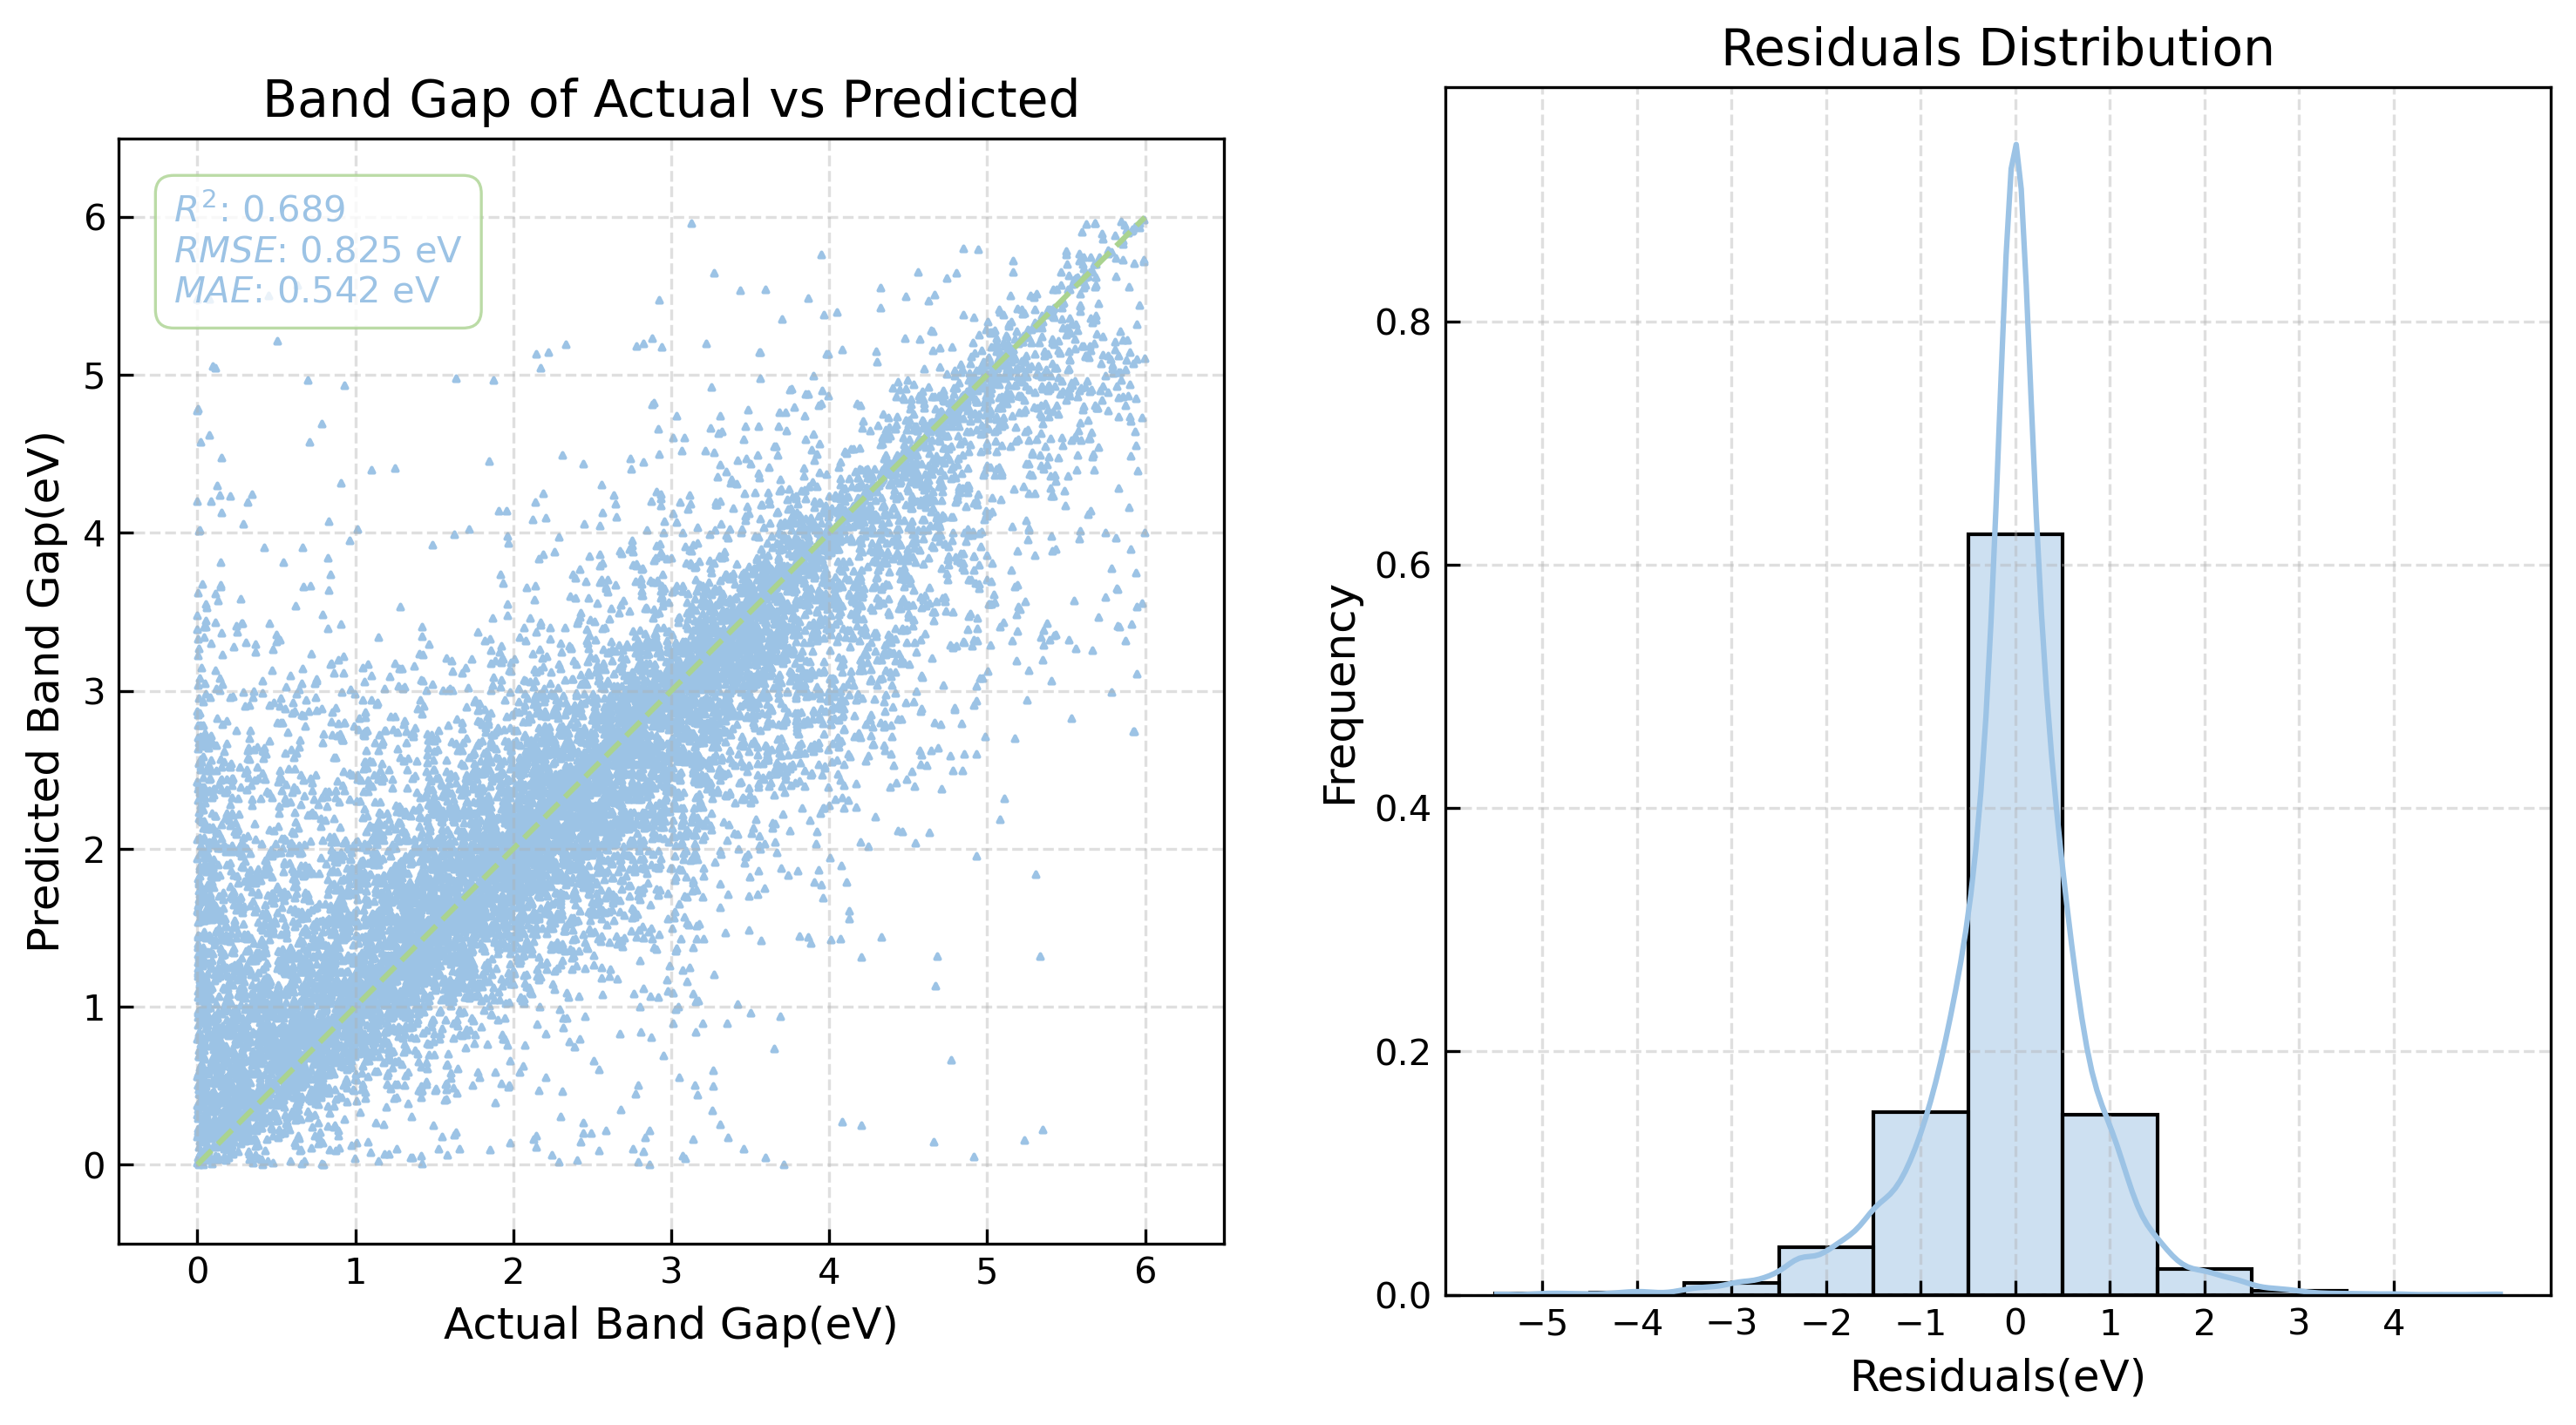


Model Evaluation Results:
Test set: R²: 0.6886 RMSE: 0.8248 MAE: 0.5420
[Test DFT -> EXP] Evaluating DFT KNN on EXP test set:


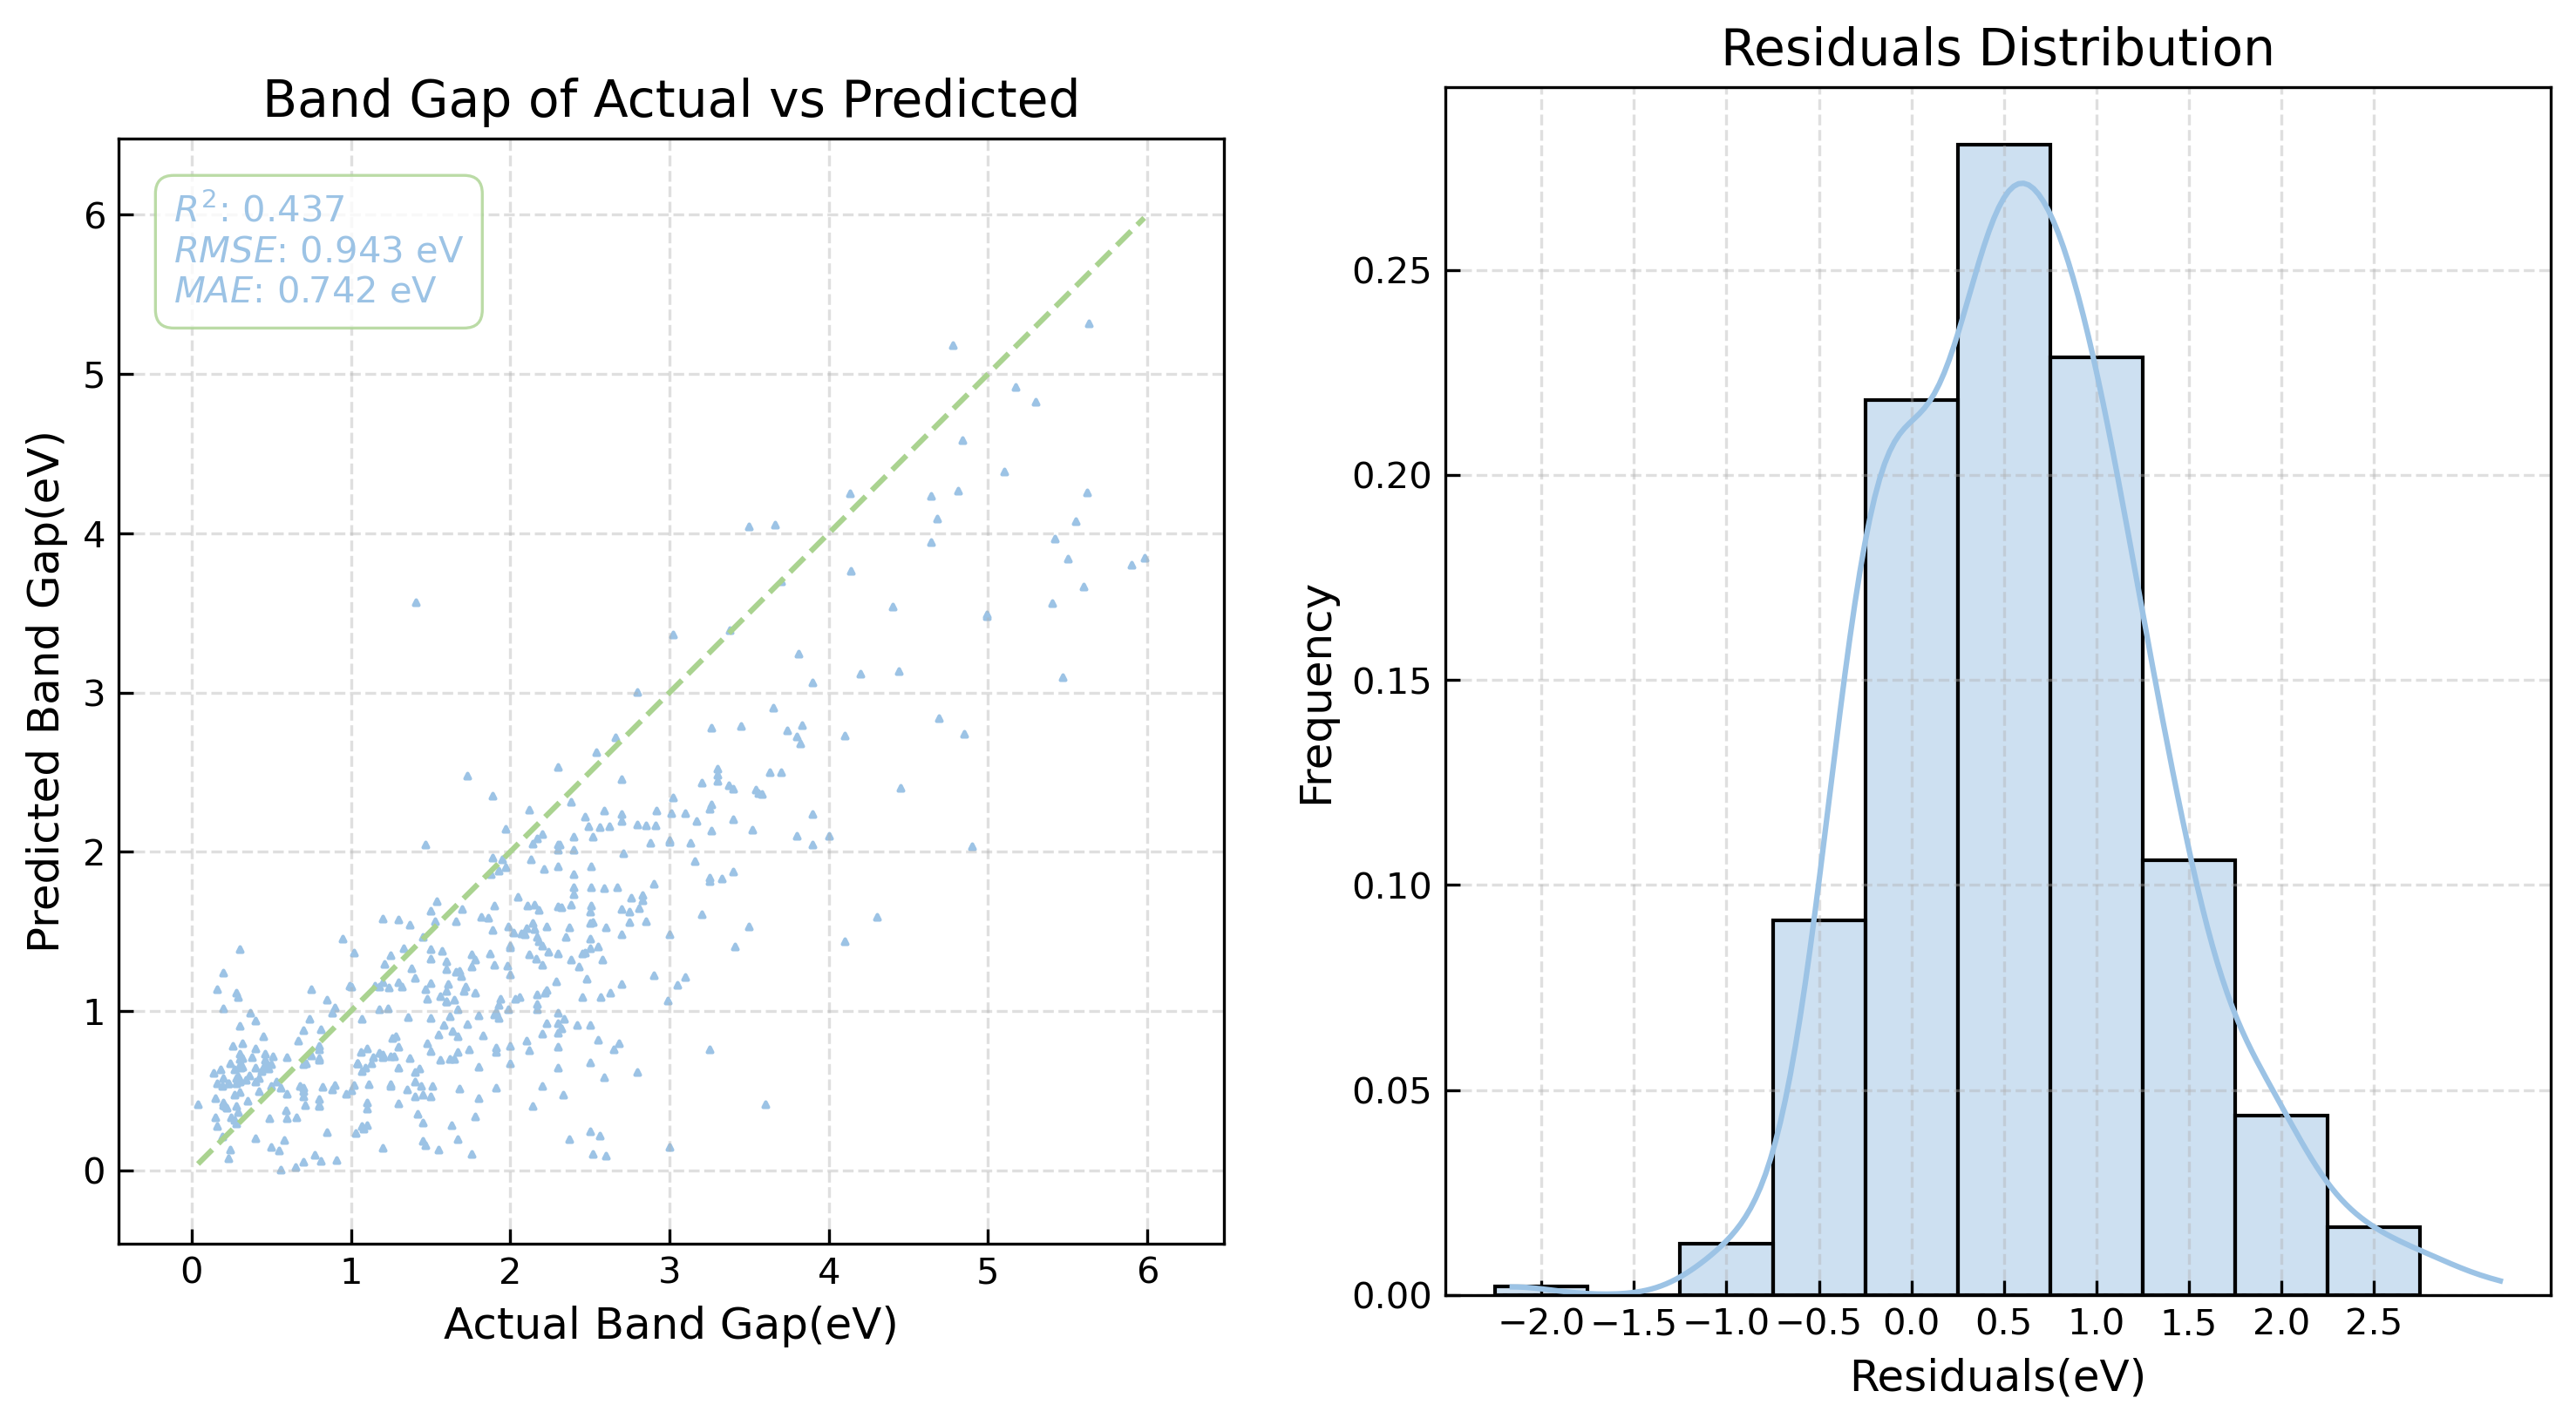


Model Evaluation Results:
Test set: R²: 0.4368 RMSE: 0.9431 MAE: 0.7418


In [20]:
# 
# Train the model with the best hyperparameters on the entire training set
# using the best hyperparameters from the random search
knn_best = KNeighborsRegressor(n_neighbors=24, weights='distance', p=1, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(knn_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [21]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,KNN,Train,dft,dft,0.990293,0.145484,0.037687
1,KNN,Test,dft,dft,0.688624,0.824812,0.541978
2,KNN,Test,dft,exp,0.436764,0.943127,0.741800


### EXP Model

In [22]:
# using random search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimization begin...")
# define the parameter distributions  for the KNN model
param_distributions = {
    'n_neighbors': np.arange(3, 100, 2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],    
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# create an model
knn = KNeighborsRegressor(n_jobs=-1)
# create a randomized search CV object
# using n_iter=50 for a faster search, you can increase this for better results
# forget to assign metrics score, the default is R2 score
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_distributions,
                n_iter=100, cv=kf, verbose=2, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True,  n_jobs=-1)

# fit the model to the training data
random_search.fit(exp_train_X, exp_train_y)


['EXP KNN'] HP optimization begin...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsRegressor(n_jobs=-1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-random_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(random_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_n_neighbors', 
                               'param_weights', 'param_p',
                               'train_rmse', 'test_rmse']] 

# save the results to a csv file
results_sorted.to_csv(os.path.join(current_path, 'exp_random_search_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': np.int64(7)}
Best Cross-Validation RMSE: 0.7064


,rank_test_score,param_n_neighbors,param_weights,param_p,train_rmse,test_rmse
17,1,7,distance,1,0.012254,0.706427
40,2,5,distance,1,0.012254,0.707325
56,3,17,distance,1,0.012254,0.731031
82,4,19,distance,1,0.012254,0.735548
99,5,3,uniform,1,0.497512,0.743510


### Overfitting check

####################################################################################################
[EXP - KNN] Training KNN on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[Train_error] Evaluating EXP KNN on EXP train set:
[Test EXP -> EXP] Evaluating EXP KNN on EXP test set:


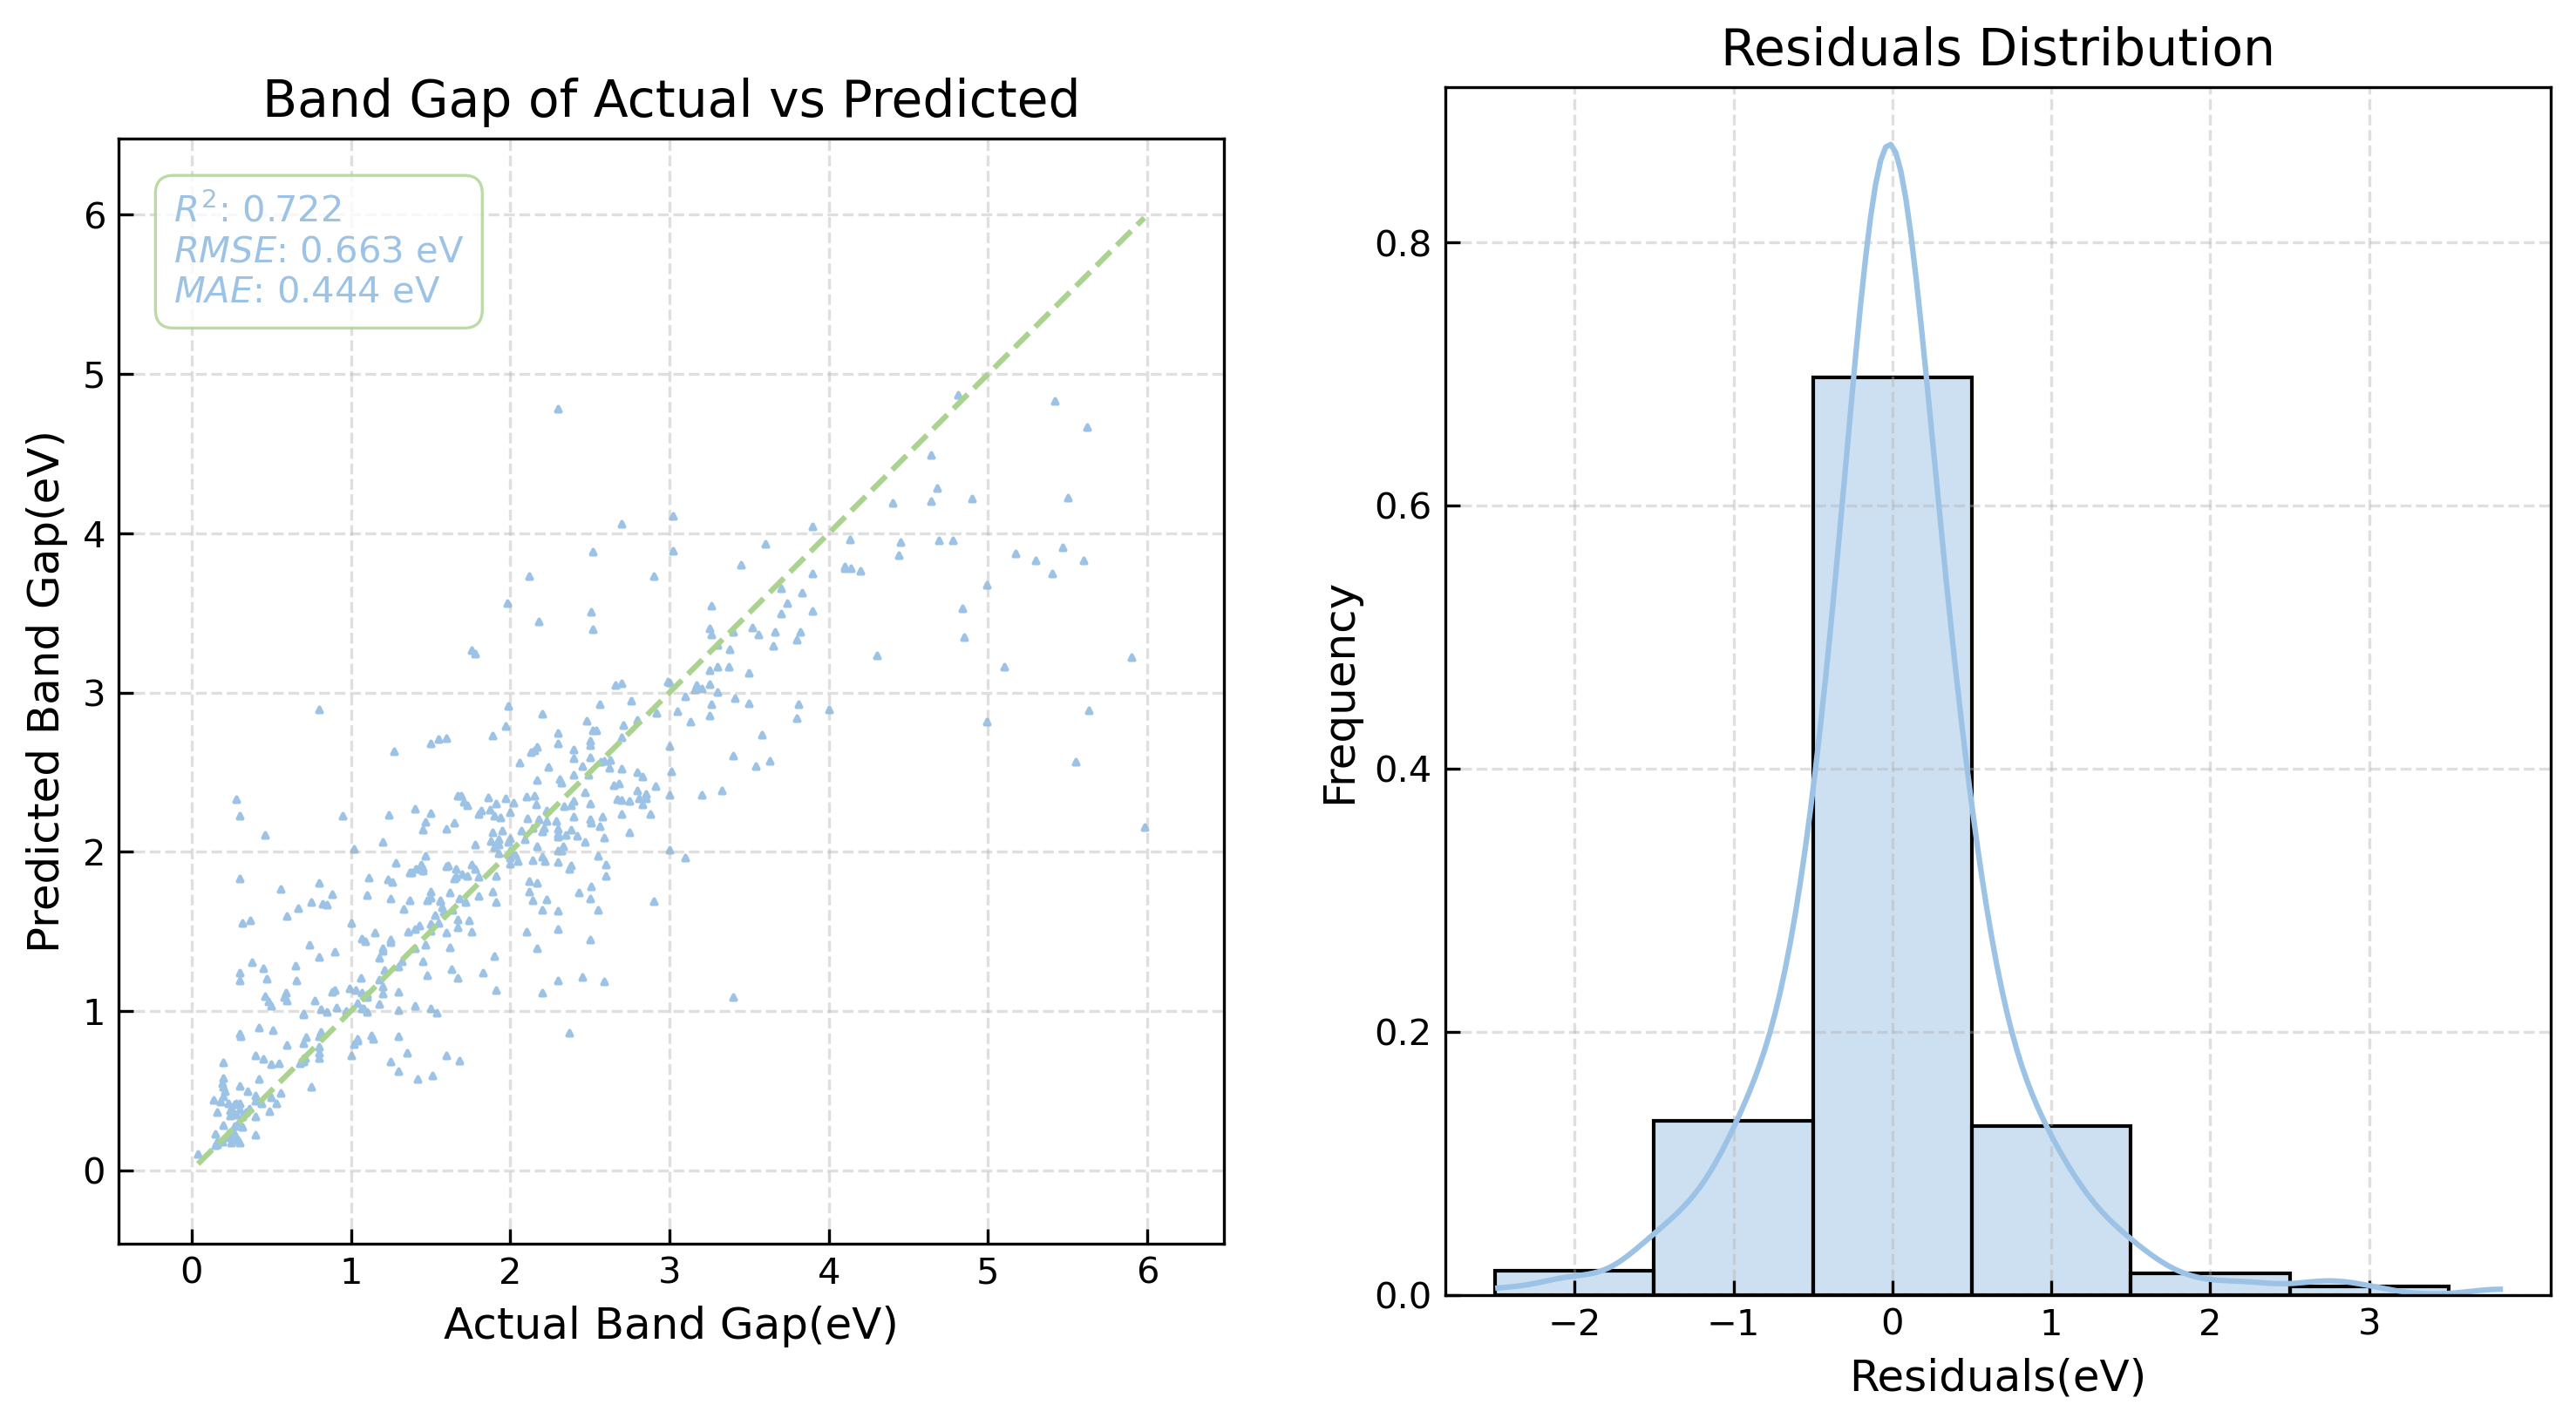


Model Evaluation Results:
Test set: R²: 0.7219 RMSE: 0.6627 MAE: 0.4443
[Test EXP -> DFT] Evaluating EXP KNN on DFT test set:


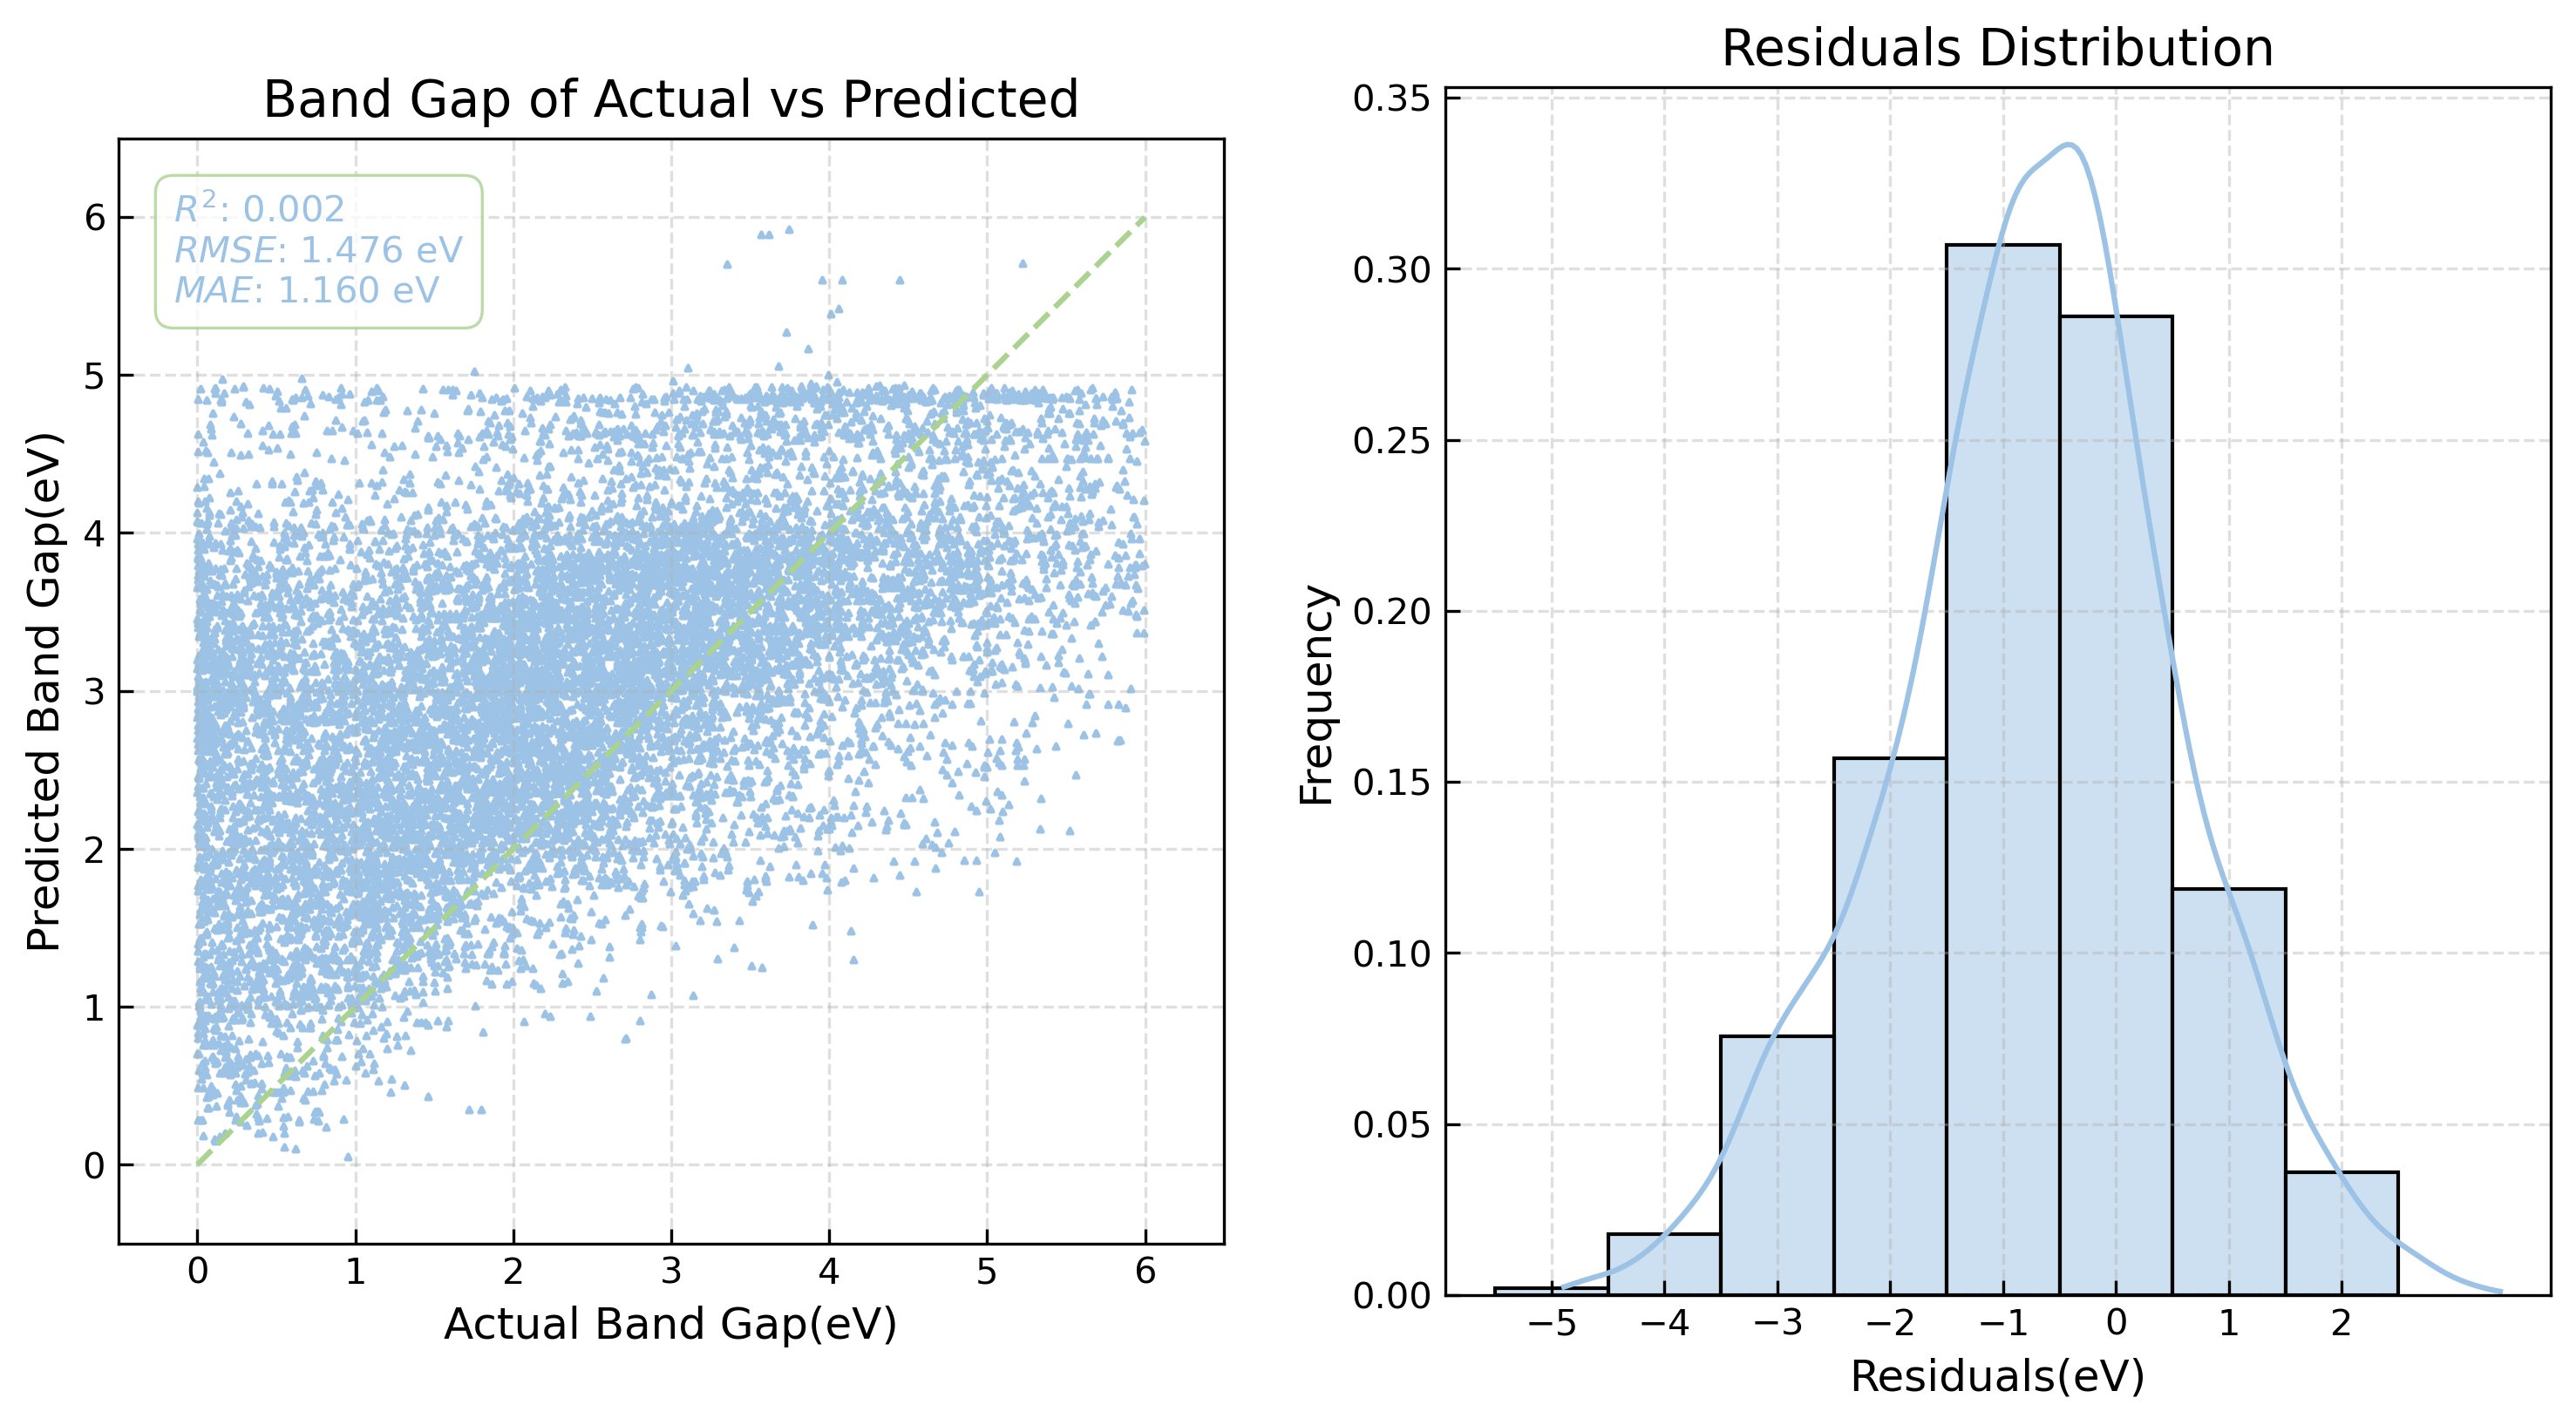


Model Evaluation Results:
Test set: R²: 0.0024 RMSE: 1.4763 MAE: 1.1603


In [28]:
# 
# Train the model with the best hyperparameters on the entire training set
knn_best = KNeighborsRegressor(n_neighbors=7, weights='distance', p=1, n_jobs=-1)

# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(knn_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
# metrics = exp_model.evaluate(exp_train_X, exp_train_y)
# model_metrics.loc[len(model_metrics)] = {
# 'Model': MODEL_NAME,
# 'Error_Type': 'Train',
# 'Train_set': 'exp',
# 'Test_set': 'exp',
# 'R²': metrics['r2'],
# 'RMSE': metrics['rmse'],
# 'MAE': metrics['mae']
# }

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [29]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,KNN,Test,exp,exp,0.721881,0.662736,0.444274
1,KNN,Test,exp,dft,0.002442,1.476324,1.160315
